In [6]:
!pip install numpy==1.24.3
!pip install scikit-learn==1.2.2

In [7]:
import sklearn
print(sklearn.__version__)

1.2.2


In [8]:
import sklearn
import cv2
import numpy as np
import pickle
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from typing import List, Tuple, Union
from sklearn.metrics.pairwise import euclidean_distances # Import euclidean_distances


In [9]:
import numpy as np
from collections import defaultdict

# === Load chart from file ===
def load_chart_from_file(filepath):
    chart = defaultdict(list)
    with open(filepath, "r") as f:
        for line in f:
            biomarker, val, h, s, v = line.strip().split(",")
            hsv = np.array([float(h), float(s), float(v)], dtype=np.float32)
            chart[biomarker].append((hsv, val))
    return chart

# === Match function ===
def match_to_chart(input_hsv, biomarker, chart):
    matches = chart.get(biomarker, [])
    if not matches:
        return "Unknown"
    distances = [np.linalg.norm(input_hsv - ref_hsv) for ref_hsv, _ in matches]
    closest_index = np.argmin(distances)
    return matches[closest_index][1]

In [10]:
def rotate_and_save(image_path, output_path):
    """Rotates an image 90 degrees counterclockwise and saves it.

    Args:
        image_path: Path to the input image file.
        output_path: Path to save the rotated image.
    """
    try:
        # Load the image using OpenCV
        img = cv2.imread(image_path)

        if img is None:
            print(f"Error: Could not read image at {image_path}")
            return

        # Rotate the image 90 degrees counterclockwise
        rotated_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Save the rotated image
        cv2.imwrite(output_path, rotated_img)
        print(f"Rotated image saved to {output_path}")

    except Exception as e:
        print(f"An error occurred: {e}")



In [11]:
def extract_strip(image_path = "rotated.jpg", debug: bool = False):
  # Load the image
  image = cv2.imread(image_path)

  rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Convert to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Apply Gaussian blur
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)

  # Use edge detection (Canny)
  edges = cv2.Canny(blurred, 50, 150)

  if debug:
      plt.figure(figsize=(12, 4))
      plt.subplot(131)
      plt.imshow(rgb_image)
      plt.title("Original Image")
      plt.axis('off')

      plt.subplot(132)
      plt.imshow(blurred, cmap='gray')
      plt.title("Blurred Image")
      plt.axis('off')

      plt.subplot(133)
      plt.imshow(edges, cmap='gray')
      plt.title("Edge Detection")
      plt.axis('off')
      plt.tight_layout()
      plt.show()

  # Find contours
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Find the largest contour (assumed to be the strip)
  strip_contour = max(contours, key=cv2.contourArea)

  # Create a mask and extract the strip
  mask = np.zeros_like(gray)
  cv2.drawContours(mask, [strip_contour], -1, 255, thickness=cv2.FILLED)
  strip = cv2.bitwise_and(image, image, mask=mask)

  # Find the bounding rectangle of the strip
  x, y, w, h = cv2.boundingRect(strip_contour)
  strip_roi = image[y:y+h, x:x+w]

  # Convert extracted strip to HSV (for color segmentation)
  hsv = cv2.cvtColor(strip_roi, cv2.COLOR_BGR2HSV)

  # Define color thresholds to extract reagent patches
  lower_bound = np.array([0, 50, 50])  # Adjust based on the strip colors
  upper_bound = np.array([180, 255, 255])

  # Create a mask to detect the patches
  patch_mask = cv2.inRange(hsv, lower_bound, upper_bound)

  # Find contours for patches
  patch_contours, _ = cv2.findContours(patch_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Sort patches top to bottom
  patch_contours = sorted(patch_contours, key=lambda c: cv2.boundingRect(c)[1])

  # Extract and save each patch
  patches = []
  for i, patch in enumerate(patch_contours):
      px, py, pw, ph = cv2.boundingRect(patch)
      patch_roi = strip_roi[py:py+ph, px:px+pw]
      patches.append(patch_roi)
      cv2.imwrite(f"patch_{i}.png", patch_roi)

  if debug:
        plt.subplot(132)
        plt.imshow(cv2.cvtColor(patch_roi, cv2.COLOR_BGR2RGB))
        plt.title("Extracted Strip")
        plt.axis('off')

        plt.subplot(133)
        gray_roi = cv2.cvtColor(patch_roi, cv2.COLOR_BGR2GRAY)
        plt.imshow(gray_roi, cmap='gray')
        plt.title("Grayscale Strip")
        plt.axis('off')
        plt.tight_layout()
        plt.show()


  return "patch_0.png"

In [12]:
def extract_patch_hsv_values(image_path: str, num_clusters: int = 10, debug: bool = False) -> np.ndarray:
    """
    Extract and return dominant patch colors from a test strip image in HSV format.

    Args:
        image_path: Path to the cropped test strip image.
        num_clusters: Number of color patches expected.
        debug: If True, shows the sorted RGB color patches.

    Returns:
        A NumPy array of HSV values with shape (num_clusters, 3)
    """
    # Load and convert image to RGB
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Reshape image data for K-Means
    reshaped_image = image_rgb.reshape((-1, 3))

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    kmeans.fit(reshaped_image)
    dominant_colors = kmeans.cluster_centers_.astype(int)

    # Sort colors by vertical position
    labels = kmeans.labels_.reshape(image.shape[:2])
    patch_positions = [np.mean(np.where(labels == i)[0]) for i in range(num_clusters)]
    sorted_indices = np.argsort(patch_positions)
    sorted_colors = dominant_colors[sorted_indices]

    # Convert sorted RGB to HSV
    sorted_colors_bgr = np.array(sorted_colors, dtype=np.uint8).reshape(1, -1, 3)
    sorted_colors_hsv = cv2.cvtColor(sorted_colors_bgr, cv2.COLOR_RGB2HSV)[0]

    if debug:
        import matplotlib.pyplot as plt
        sorted_colors_rgb = np.array(sorted_colors).reshape(-1, 1, 3)
        fig, ax = plt.subplots(figsize=(2, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(sorted_colors_rgb)
        plt.show()

        from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

        silhouette = silhouette_score(reshaped_image, kmeans.labels_)
        dbi = davies_bouldin_score(reshaped_image, kmeans.labels_)
        chi = calinski_harabasz_score(reshaped_image, kmeans.labels_)

        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"Davies-Bouldin Index: {dbi:.4f}")
        print(f"Calinski-Harabasz Index: {chi:.2f}")


    return sorted_colors_hsv

In [13]:
import cv2
import numpy as np
from typing import List
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def extract_patch_hsv_contours_debug(image_path: str, num_patches: int = 10) -> np.ndarray:
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")

    # Original
    print("Original Image:")
    cv2_imshow(image)

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    print("Grayscale Image:")
    cv2_imshow(image_gray)

    # Show pixel intensity range
    min_val = np.min(image_gray)
    max_val = np.max(image_gray)
    mean_val = np.mean(image_gray)
    print(f"Pixel intensity - min: {min_val}, max: {max_val}, mean: {mean_val:.2f}")

    # Set threshold dynamically (you can adjust the offset if needed)
    threshold_value = int(mean_val + 20)
    threshold_value = np.clip(threshold_value, 100, 250)
    print(f"Using dynamic threshold value: {threshold_value}")

    _, thresh = cv2.threshold(image_gray, threshold_value, 255, cv2.THRESH_BINARY_INV)
    print("Thresholded Image:")
    cv2_imshow(thresh)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_contours = image.copy()
    cv2.drawContours(image_contours, contours, -1, (0, 255, 0), 1)
    print(f"Total contours found: {len(contours)}")
    cv2_imshow(image_contours)

    # Filter and sort contours by vertical position
    patch_contours = sorted(
        [cnt for cnt in contours if cv2.contourArea(cnt) > 50],
        key=lambda c: cv2.boundingRect(c)[1]
    )

    print(f"Contours after filtering: {len(patch_contours)}")

    hsv_values: List[np.ndarray] = []
    image_boxes = image.copy()

    for i, cnt in enumerate(patch_contours[:num_patches]):
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)
        patch = image_hsv[y:y+h, x:x+w]
        avg_hsv = cv2.mean(patch)[:3]
        hsv_values.append(avg_hsv)
        print(f"Patch {i+1} at (x={x}, y={y}, w={w}, h={h}) → HSV: {avg_hsv}")

    print("Detected Patch Boxes:")
    cv2_imshow(image_boxes)

    # Show color swatches
    hsv_array = np.array(hsv_values, dtype=np.uint8)
    if len(hsv_array) > 0:
        rgb_strip = np.array([[cv2.cvtColor(np.uint8([[h]]), cv2.COLOR_HSV2RGB)[0][0] for h in hsv_array]], dtype=np.uint8)
        plt.imshow(rgb_strip.reshape(-1, 1, 3))
        plt.axis('off')
        plt.title("Extracted Patch Colors")
        plt.show()

    return hsv_array


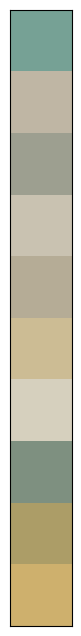

Silhouette Score: 0.4184
Davies-Bouldin Index: 0.7762
Calinski-Harabasz Index: 10910.93
[[ 82  68 161]
 [ 20  36 191]
 [ 34  24 159]
 [ 21  30 201]
 [ 21  44 181]
 [ 21  70 204]
 [ 23  29 214]
 [ 63  32 144]
 [ 23 102 172]
 [ 21 120 206]]


In [15]:
from logging import debug

image_path = "protein300c.jpg"
hsv_values = extract_patch_hsv_values(image_path, num_clusters=10, debug=True)
print(hsv_values)

Original Image:


Grayscale Image:


Pixel intensity - min: 127, max: 223, mean: 179.48
Using dynamic threshold value: 199
Thresholded Image:


Total contours found: 17


Contours after filtering: 6
Patch 1 at (x=0, y=0, w=25, h=114) → HSV: (30.393684210526313, 38.85263157894737, 189.12456140350875)
Patch 2 at (x=0, y=115, w=25, h=24) → HSV: (20.92666666666667, 30.448333333333334, 198.90333333333334)
Patch 3 at (x=0, y=145, w=25, h=24) → HSV: (21.83666666666667, 39.50166666666667, 183.81833333333336)
Patch 4 at (x=0, y=170, w=25, h=34) → HSV: (51.17647058823529, 31.34941176470588, 168.71647058823527)
Patch 5 at (x=0, y=205, w=25, h=53) → HSV: (20.441509433962263, 88.73811320754716, 194.17735849056604)
Patch 6 at (x=0, y=259, w=25, h=27) → HSV: (24.599999999999998, 96.3437037037037, 207.5511111111111)
Detected Patch Boxes:


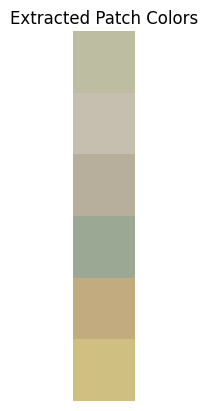

[[ 30  38 189]
 [ 20  30 198]
 [ 21  39 183]
 [ 51  31 168]
 [ 20  88 194]
 [ 24  96 207]]


In [16]:
hsv_values = extract_patch_hsv_contours_debug(image_path, num_patches=10)
print(hsv_values)

In [20]:
input_hsv = [[63,  32, 144]]

# KNN model inference

In [21]:
with open("/content/drive/MyDrive/models/protein_model.pkl", 'rb') as file:
          model = pickle.load(file)


# Predict using the model
prediction = model.predict(input_hsv)

print(prediction)

[300.]


# Colour Chart Inference

In [23]:
# === Inference Example ===
color_chart = load_chart_from_file("color_chart.txt")

biomarker = "protein"
match = match_to_chart([input_hsv], biomarker, color_chart)

print(f"Input HSV: {input_hsv} → Closest match in '{biomarker}': {match}")


Input HSV: [[63, 32, 144]] → Closest match in 'protein': 15


# Results

In [24]:
import pickle
import numpy as np
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [25]:
def interpret(model_paths,hsv_values):
  results = {}

  # Iterate over each model and test with the corresponding HSV values
  for model_path, hsv_value in zip(model_paths, hsv_values):
      # Load the model
      with open(model_path, 'rb') as file:
          model = pickle.load(file)

      # Predict using the model
      prediction = model.predict([hsv_value])

      results[model_path.split('/')[-1].removesuffix("_model.pkl")] = prediction[0]

      # Print the result
      # print(f"Model: {model_path.split('/')[-1]}, HSV: {hsv_value}, Prediction: {prediction[0]}\n")

  return results

def interpret_results(results):
    interpretations = {}

    # Bilirubin (assumed units; normally not detectable)
    bilirubin = results.get('bilirubin', None)
    if bilirubin is None:
        interpretations['bilirubin'] = "no data"
    else:
        if bilirubin == 0:
            interpretations['bilirubin'] = "normal"
        elif 0 < bilirubin < 2:
            interpretations['bilirubin'] = "caution"
        else:
            interpretations['bilirubin'] = "danger"

    # Blood in urine (normal: not detected / 0; any detection is abnormal)
    blood = results.get('blood', None)
    if blood is None:
        interpretations['blood'] = "no data"
    else:
        # assuming numeric values: 0 is normal; small amounts caution; higher values danger
        if blood == 0 or blood == "not detected":
            interpretations['blood'] = "normal"
        elif isinstance(blood, (int, float)) and 0 < blood <= 50:
            interpretations['blood'] = "caution"
        else:
            interpretations['blood'] = "danger"

    # Glucose (normal urine glucose: 0 to 15 mg/dL; high values indicate abnormal)
    glucose = results.get('glucose', None)
    if glucose is None:
        interpretations['glucose'] = "no data"
    else:
        if 0 <= glucose <= 15:
            interpretations['glucose'] = "normal"
        elif 15 < glucose <= 100:
            interpretations['glucose'] = "caution"
        else:
            interpretations['glucose'] = "danger"

    # Ketones (normally negative or zero)
    ketones = results.get('ketones', None)
    if ketones is None:
        interpretations['ketones'] = "no data"
    else:
        if ketones == 0 or ketones == "neg":
            interpretations['ketones'] = "normal"
        elif 0 < ketones < 1.5:
            interpretations['ketones'] = "caution"
        else:
            interpretations['ketones'] = "danger"

    # Leukocytes (normal: few; typically 0-5 WBCs per high-power field; higher counts are abnormal)
    leukocytes = results.get('leukocytes', None)
    if leukocytes is None:
        interpretations['leukocytes'] = "no data"
    else:
        if leukocytes <= 5:
            interpretations['leukocytes'] = "normal"
        elif 5 < leukocytes <= 20:
            interpretations['leukocytes'] = "caution"
        else:
            interpretations['leukocytes'] = "danger"

    # Nitrite (normal is negative)
    nitrite = results.get('nitrite', None)
    if nitrite is None:
        interpretations['nitrite'] = "no data"
    else:
        if isinstance(nitrite, str) and nitrite.lower() in ["neg", "negative"]:
            interpretations['nitrite'] = "normal"
        else:
            interpretations['nitrite'] = "danger"

    # pH (normal range: 4.6 to 8.0)
    pH = results.get('pH', None)
    if pH is None:
        interpretations['pH'] = "no data"
    else:
        if 4.6 <= pH <= 8.0:
            interpretations['pH'] = "normal"
        elif (pH < 4.6 and pH >= 4.0) or (pH > 8.0 and pH <= 8.5):
            interpretations['pH'] = "caution"
        else:
            interpretations['pH'] = "danger"

    # Protein (normal: 0 to 14 mg/dL)
    protein = results.get('protein', None)
    if protein is None:
        interpretations['protein'] = "no data"
    else:
        if 0 <= protein <= 14:
            interpretations['protein'] = "normal"
        elif 14 < protein <= 30:
            interpretations['protein'] = "caution"
        else:
            interpretations['protein'] = "danger"

    # Specific Gravity (normal range: 1.010 to 1.030)
    sp_gravity = results.get('specific_gravity', None)
    if sp_gravity is None:
        interpretations['specific_gravity'] = "no data"
    else:
        if 1.010 <= sp_gravity <= 1.030:
            interpretations['specific_gravity'] = "normal"
        elif (1.000 <= sp_gravity < 1.010) or (1.030 < sp_gravity <= 1.040):
            interpretations['specific_gravity'] = "caution"
        else:
            interpretations['specific_gravity'] = "danger"

    # Urobilinogen (normal: approximately 0.2 to 1.0 mg/dL)
    urobilinogen = results.get('urobilinogen', None)
    if urobilinogen is None:
        interpretations['urobilinogen'] = "no data"
    else:
        if 0.2 <= urobilinogen <= 1.0:
            interpretations['urobilinogen'] = "normal"
        elif 1.0 < urobilinogen <= 2.0:
            interpretations['urobilinogen'] = "caution"
        else:
            interpretations['urobilinogen'] = "danger"

    return interpretations

In [26]:
# Define the HSV values for the biomarkers
hsv_values = np.array(hsv_values)

# List of model file paths
model_paths = [
    "/content/drive/MyDrive/models/glucose_model.pkl",
    "/content/drive/MyDrive/models/urobilinogen_model.pkl",
    "/content/drive/MyDrive/models/bilirubin_model.pkl",
    "/content/drive/MyDrive/models/leukocytes_model.pkl",
    "/content/drive/MyDrive/models/nitrite_model.pkl",
    "/content/drive/MyDrive/models/ketones_model.pkl",
    "/content/drive/MyDrive/models/protein_model.pkl",
    "/content/drive/MyDrive/models/specific_gravity_model.pkl",
    "/content/drive/MyDrive/models/pH_model.pkl",
    "/content/drive/MyDrive/models/blood_model.pkl",
]

results = interpret(model_paths,hsv_values)
interpretations = interpret_results(results)

In [27]:
results = interpret(model_paths,hsv_values)
interpretations = interpret_results(results)

In [ ]:
print(f"Protein: {results['protein']}")
print(f"Protein: {interpretations['protein']}")

print(f"Glucose: {results['glucose']}")
print(f"Glucose: {interpretations['glucose']}")

print(f"pH: {results['pH']}")
print(f"pH: {interpretations['pH']}")

print(f"Specific Gravity: {results['specific_gravity']}")
print(f"Specific Gravity: {interpretations['specific_gravity']}")

print(f"Blood: {results['blood']}")
print(f"Blood: {interpretations['blood']}")


Protein: 0.0
Protein: normal
Glucose: 100.0
Glucose: caution
pH: 6.5
pH: normal
Specific Gravity: 1.0290000000000001
Specific Gravity: normal
Blood: 0.0
Blood: normal
